## Modeling

This notebook aims to predict which different types of plants will grow on a particular ground type in Roosevelt National Forest of northern Colorado.
### Steps:
* Exploratory Data Analysis (EDA)
* Data Preprosessing
* Feature engineering
* Classification using XgBoost
* Cross-validation
* Grid-Search

In [100]:
import numpy as np
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn import model_selection
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
from matplotlib import pyplot as plt

In [120]:
# load the data
df_train = pd.read_csv('./input/train.csv', index_col='Id')
df_test  = pd.read_csv('./input/test.csv', index_col='Id')

In [121]:
df_train_y = df_train.pop('Cover_Type')
df_train_x = df_train

### Feature Engineering

In [122]:
# Eliminate some useless features
dropped_features = ['Soil_Type15', 'Soil_Type7', 'Soil_Type8', 'Soil_Type25', 'Soil_Type36', 'Soil_Type9',
                   'Soil_Type34', 'Soil_Type28', 'Soil_Type27', 'Soil_Type21', 'Soil_Type26', 'Soil_Type37',
                   'Soil_Type14', 'Soil_Type19', 'Soil_Type18', 'Soil_Type1', 'Soil_Type16', 'Soil_Type5',
                   'Vertical_Distance_To_Hydrology', 'Hillshade_3pm']

In [123]:
df_train_x.drop(dropped_features, axis=1, inplace = True)
df_test.drop(dropped_features, axis=1, inplace = True)

In [124]:
# Split the data
X_train, X_val, y_train, y_val = train_test_split(df_train_x, df_train_y, test_size=0.2, random_state=42)


In [125]:
print("X_train shape: ", X_train.shape, "\ny_train shape: ", y_train.shape)
print("X_val shape: ", X_val.shape, "\ny_val shape: ", y_val.shape)

X_train shape:  (12096, 34) 
y_train shape:  (12096,)
X_val shape:  (3024, 34) 
y_val shape:  (3024,)


### Forecast

In [67]:
# Grid search to find best parameters
model_xgb = xgb.XGBClassifier()
parameters = {
                # XGBClassifier
                'learning_rate': [0.1, 0.2, 0.3],
                'max_depth': [7],
                'n_estimators': [300, 500],
                'gamma': [0.1, 0.2],
                'min_child_weight': [6],
            }

CV = model_selection.GridSearchCV(model_xgb, parameters, scoring = 'accuracy')
CV.fit(X_train, y_train)   

print('Best score and parameter combination = ')
print(CV.best_score_)    
print(CV.best_params_)   

C:\Users\Merve\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Best score and parameter combination = 
0.8392030423280423
{'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 7, 'min_child_weight': 6, 'n_estimators': 500}


In [132]:
model = xgb.XGBClassifier(gamma=0.1, learning_rate=0.3, max_depth=7, min_child_weight=6,
                                                    objective= 'multi:softmax', n_estimators=500)
model.fit(X_train, y_train, eval_metric='merror')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, gamma=0.1, learning_rate=0.3,
              max_delta_step=0, max_depth=7, min_child_weight=6, missing=None,
              n_estimators=300, n_jobs=1, nthread=None,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
              subsample=1)

In [133]:
model.score(X_train, y_train)

1.0

In [134]:
y_preds = model.predict(X_val)
accuracy_score(y_val, y_preds)

0.8683862433862434

In [136]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(model, random_state = 42).fit(X_val,y_val)
eli5.show_weights(perm, feature_names = X_val.columns.tolist())

Weight,Feature
0.5806 ± 0.0116,Elevation
0.1378 ± 0.0131,Horizontal_Distance_To_Roadways
0.1136 ± 0.0101,Horizontal_Distance_To_Fire_Points
0.0989 ± 0.0025,Horizontal_Distance_To_Hydrology
0.0478 ± 0.0056,Hillshade_9am
0.0307 ± 0.0047,Wilderness_Area1
0.0304 ± 0.0073,Hillshade_Noon
0.0185 ± 0.0016,Wilderness_Area3
0.0170 ± 0.0040,Wilderness_Area4
0.0151 ± 0.0026,Aspect


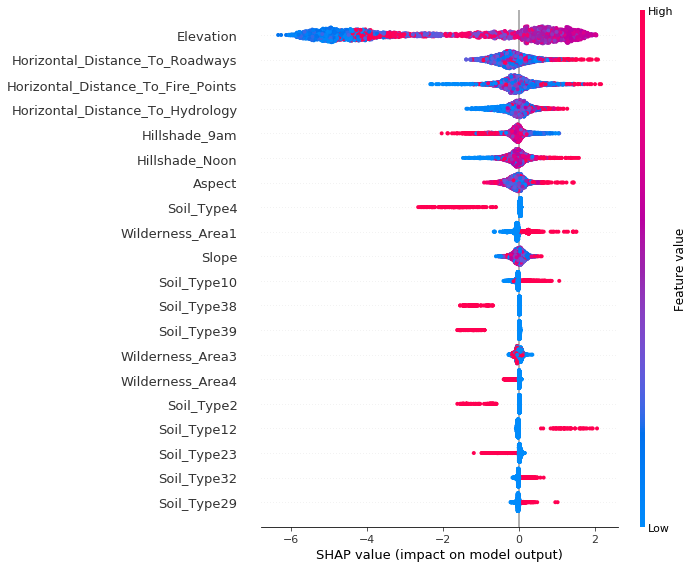

In [137]:
import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_val)
shap.summary_plot(shap_values[1], X_val)

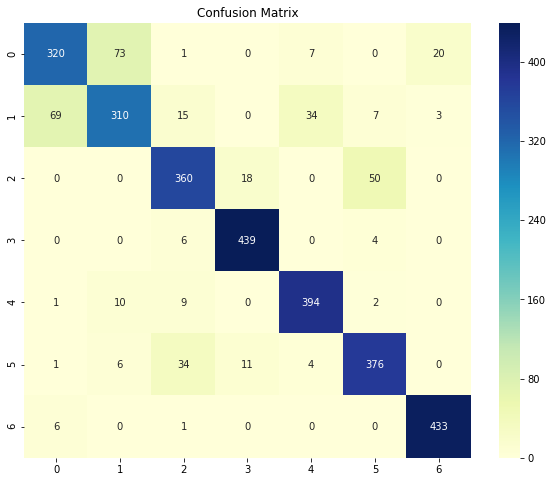

In [129]:
plt.figure(figsize=(10, 8))
conf_matrix = confusion_matrix(y_val, y_preds)
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap="YlGnBu").set_title("Confusion Matrix")
plt.show()
plt.tight_layout()
plt.close()

In [130]:
test_pred = model.predict(df_test)

In [131]:
# Save test predictions to file
output = pd.DataFrame({'ID': df_test.index, 'Cover_Type': test_pred})
output.to_csv('./output/submission.csv', index=False)